In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from colorization_unet import ColorizationUNet

model = ColorizationUNet()
# 创建一个示例灰度图像，尺寸为(1, 1, 160, 160)
input_image = torch.randn(1, 1, 160, 160)
# 前向传播
output_image = model(input_image)
print(output_image.shape)  # 输出尺寸应为(1, 3, 160, 160)


torch.Size([1, 3, 160, 160])


In [2]:
model

ColorizationUNet(
  (enc1): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc2): ConvBlock(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc4): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc5): ConvBlock(
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride

In [ ]:
# 读取并预处理灰度图像
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
from skimage import io

# 设置模型为评估模式
model.eval()

# 读取并预处理灰度图像
from PIL import Image
import torchvision.transforms as transforms
# 保存彩色图像
import matplotlib.pyplot as plt

# 定义与训练时相同的变换
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])
# 将模型移动到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load('./checkpoints/colorization_epoch_50.pth', map_location=device))


In [9]:
# 加载灰度图像并预处理
gray_image = Image.open('landscape/color/0.jpg').convert('L')
gray_image = io.imread('landscape/gray/0.jpg')
gray_tensor = transform(gray_image).unsqueeze(0).to(device)  # 添加批次维度并移动到设备

np.array(gray_image).shape

(150, 150)

In [ ]:
# 使用模型进行预测
with torch.no_grad():
    output_color = model(gray_tensor)

# 将输出转换为图像并保存
output_color = output_color.squeeze(0).cpu().numpy()  # 移除批次维度并移动到 CPU
output_img = np.transpose(output_color, (1, 2, 0))  # 调整维度顺序为 [H, W, C]

In [1]:
from skimage import io

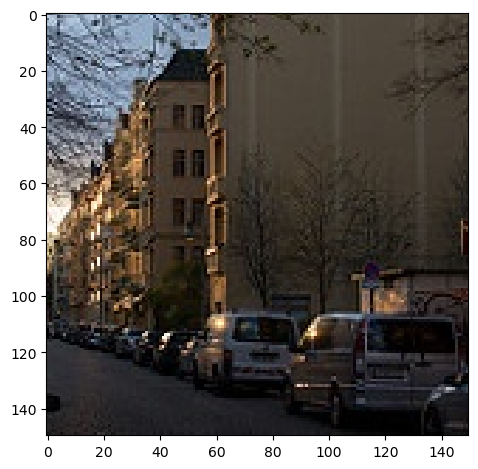

In [2]:
io.imshow("landscape/color/0.jpg")

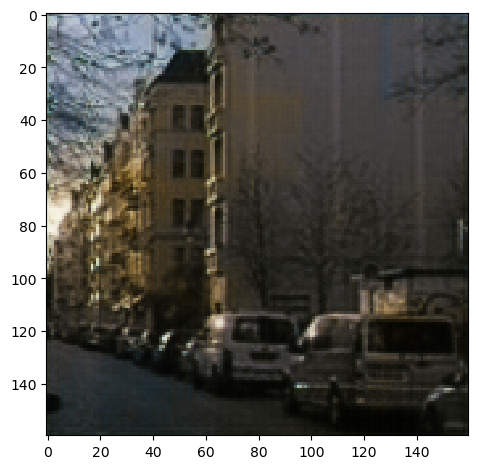

In [3]:
io.imshow("./c2.png")

In [ ]:
# from skimage import io
# 
# plt.imshow(output_img)

In [ ]:
# plt.imsave('colorized_image.png', output_img)


In [ ]:
# plt.imshow('colorized_image.png')